pipeline 만들기

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn import set_config

# 데이터 가져오기
df = pd.read_excel("dataset-uci 2.xls")

# 불필요한 데이터 삭제
df = df.drop(columns=['Obesity (%)'])
df = df.drop(index=23)

# 사용하는 속성 선택
selected_features = ['Age', 'Gender', 'Comorbidity', 'Coronary Artery Disease (CAD)',
                     'Hypothyroidism', 'Hyperlipidemia', 'Diabetes Mellitus (DM)', 'Weight',
                     'Extracellular Fluid/Total Body Water (ECF/TBW)', 'Body Protein Content (Protein) (%)',
                     'Hepatic Fat Accumulation (HFA)', 'Glucose', 'Total Cholesterol (TC)',
                     'High Density Lipoprotein (HDL)', 'Triglyceride', 'Aspartat Aminotransferaz (AST)',
                     'Alkaline Phosphatase (ALP)', 'Creatinine', 'Glomerular Filtration Rate (GFR)',
                     'C-Reactive Protein (CRP)', 'Hemoglobin (HGB)', 'Vitamin D']

X = df[selected_features].values
y = df.iloc[:, 0].values

# 훈령데이터과 데스트데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

# pipline만들기
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 정규화
    ('logreg', LogisticRegression(
        C=1.0, penalty='l2', solver='liblinear', random_state=1, max_iter=1000
    ))  # 로지스틱 회귀
])

# 모델학습
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

#AUC
from sklearn.metrics import roc_auc_score
y_prob = pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.4f}")

import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipeline.fit(X_train[train], y_train[train])
    score = pipeline.score(X_train[test], y_train[test])
    scores.append(score)
    print('폴드: %2d, 클래스 분포: %s, 정확도: %.3f' % (k+1,
          np.bincount(y_train[train]), score))

print('\nCV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

              precision    recall  f1-score   support

           0       0.76      0.79      0.78        48
           1       0.78      0.75      0.77        48

    accuracy                           0.77        96
   macro avg       0.77      0.77      0.77        96
weighted avg       0.77      0.77      0.77        96

AUC: 0.7943
폴드:  1, 클래스 분포: [100  99], 정확도: 0.652
폴드:  2, 클래스 분포: [100  99], 정확도: 0.696
폴드:  3, 클래스 분포: [101  99], 정확도: 0.727
폴드:  4, 클래스 분포: [101  99], 정확도: 0.909
폴드:  5, 클래스 분포: [101  99], 정확도: 0.818
폴드:  6, 클래스 분포: [101  99], 정확도: 0.773
폴드:  7, 클래스 분포: [101  99], 정확도: 0.864
폴드:  8, 클래스 분포: [101  99], 정확도: 0.864
폴드:  9, 클래스 분포: [101  99], 정확도: 0.773
폴드: 10, 클래스 분포: [101  99], 정확도: 0.818

CV 정확도: 0.789 +/- 0.077


In [48]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipeline,
                         X=X_train,
                         y=y_train,
                         cv=5,
                         n_jobs=1)
print('CV 정확도 점수: %s' % scores)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도 점수: [0.68888889 0.71111111 0.81818182 0.86363636 0.81818182]
CV 정확도: 0.780 +/- 0.068


In [49]:
from sklearn.model_selection import cross_validate

scores = cross_validate(estimator=pipeline,
                        X=X_train,
                        y=y_train,
                        scoring=['accuracy'],
                        cv=5,
                        n_jobs=-1)
print('CV 정확도 점수: %s' % scores['test_accuracy'])
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']),
                                 np.std(scores['test_accuracy'])))

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CV 정확도 점수: [0.68888889 0.71111111 0.81818182 0.86363636 0.81818182]
CV 정확도: 0.780 +/- 0.068


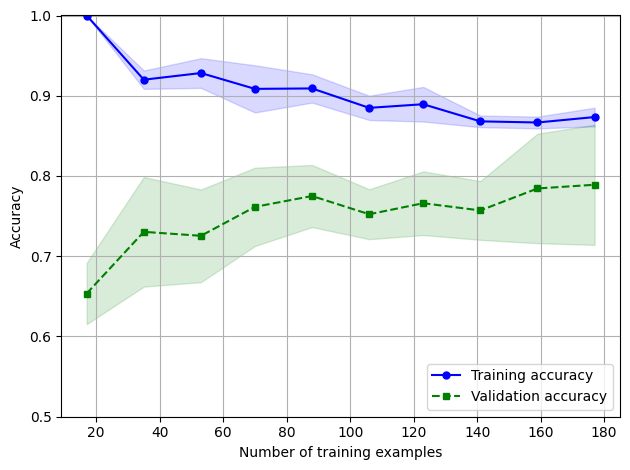

In [47]:
#학습 곡선
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 정규화
    ('logreg', LogisticRegression(
        C=1.0, penalty='l2', solver='liblinear', random_state=1, max_iter=1000
    ))  # 로지스틱 회귀
])

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipeline,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=5,
                               scoring='accuracy',
                               n_jobs=-1
                               )

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.tight_layout()
plt.show()

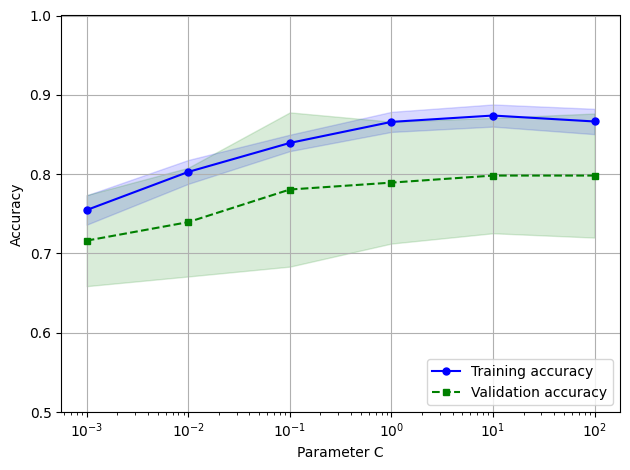

In [26]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipeline,
                X=X_train,
                y=y_train,
                param_name='logreg__C',
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.0])
plt.tight_layout()
plt.show()

Cross-Validation Accuracy

In [ ]:
from sklearn.model_selection import cross_val_score
acc_scores = cross_val_score(
    pipeline, X, y, cv=5, scoring='accuracy'
)
for i, score in enumerate(acc_scores, 1):
    print(f"Fold {i}: Accuracy = {score:.4f}")
print(f"\nMean Accuracy (5-fold CV): {acc_scores.mean():.4f}")

Fold 1: Accuracy = 0.7344
Fold 2: Accuracy = 0.7500
Fold 3: Accuracy = 0.7188
Fold 4: Accuracy = 0.7302
Fold 5: Accuracy = 0.7302

Mean Accuracy (5-fold CV): 0.7327


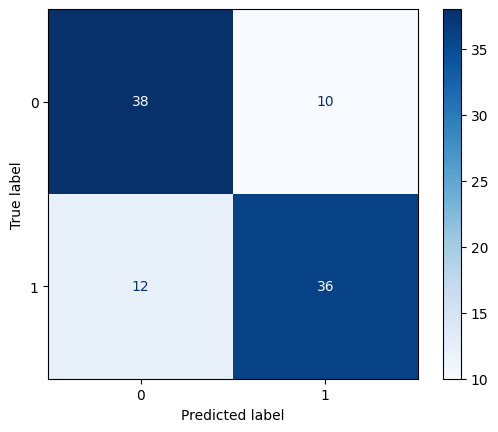

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 混同行列の作成
cm = confusion_matrix(y_test, y_pred)

# 混同行列の可視化
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

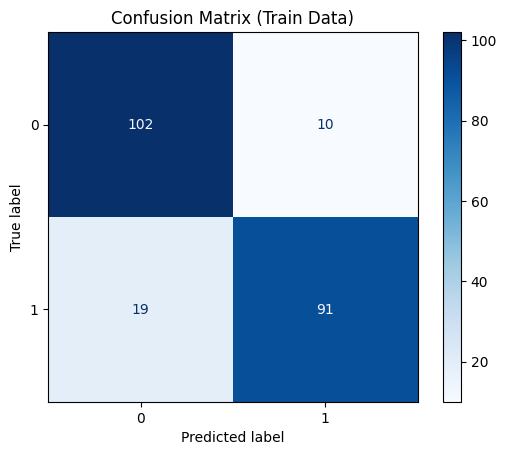

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 訓練データで予測
y_pred_train = pipeline.predict(X_train)

# 混同行列の作成
cm = confusion_matrix(y_train, y_pred_train)

# 混同行列の表示
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Train Data)")
plt.show()

ROC 곡선그리기

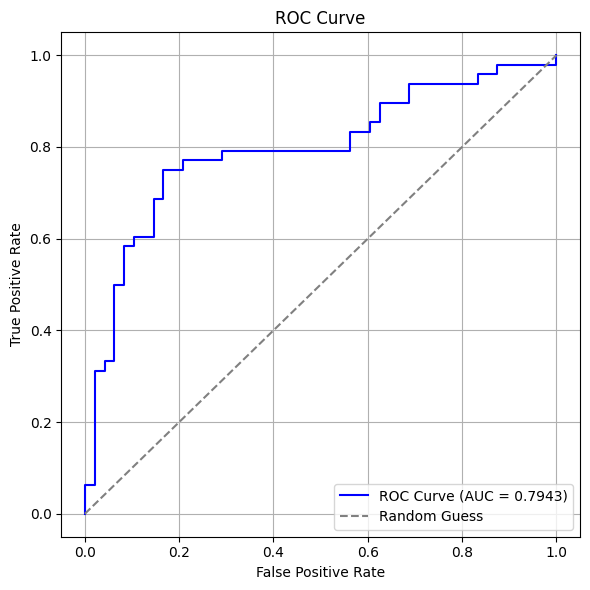

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

#그라스1의 확율을 취특
y_prob = pipeline.predict_proba(X_test)[:, 1]

# FPR TPR thresholds 정의
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# AUC계산
auc = roc_auc_score(y_test, y_prob)

# ROC곡선그리기
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()